## Custom Univariate Linear Regression
#### A custom single variable linear regression implemented using only numpy and matplotlib for graphs. We also use a linear regression model from scikit-learn as a baseline comparison.


#### Importing Libraries

In [2]:
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.available
plt.style.use("seaborn-darkgrid")

#### Importing data

In [3]:
X_feat, y_target = [], []
with open('./data/ex1data1.mat') as imported:
    for line in imported:
        line = line.strip().split(',')
        X_feat.append([1,float(line[0])]) # x_feat is a nx2 matrix, the first column is all ones
        y_target.append(float(line[1]))
X_feat, y_target = np.array(X_feat), np.array(y_target)
print(f"Shape of x feat {X_feat.shape} and number of samples {y_target.size}")

Shape of x feat (97, 2) and number of samples 97


#### Visualizing the dataset

Text(0, 0.5, 'Dependent variable')

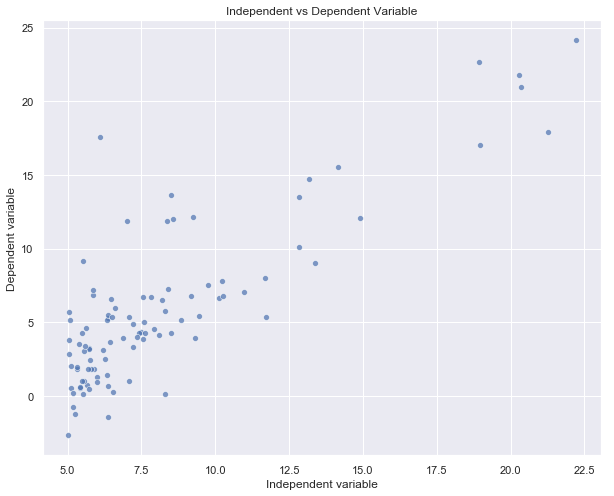

In [4]:
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(x=X_feat[:,1], y=y_target, alpha=0.7)
plt.title("Independent vs Dependent Variable")
plt.xlabel("Independent variable")
plt.ylabel("Dependent variable")

#### Creating our model with utility functions
##### Linear regression done with Gradient Descent Iterative method and Normal Equations method

In [72]:
# vectorized hypothesis function h theta_vector of x
def y_pred(X_feat, theta_vector):
    '''Matrix multiplcation method 
    X_feat must be a nx2 matrix and theta_vector must be a 2x1 vector
    normal way: theta_vector[0] + theta_vector[1] * X[:,1]'''
    return X_feat.dot(theta_vector)

# Modified Mean Squared Error Loss function (i.e. multiply by 1/2)
def mse_loss(X_feat, y_target, theta_vector):
    '''MSE Loss function
    X_feat must be a nx2 matrix, y_target must be a nx1 vector 
    and theta_vector must be a 2x1 vector'''
    predicted = y_pred(X_feat, theta_vector)
    return ((predicted-y_target)**2).mean()/2

def mse_loss_vectorized(X_feat, y_target, theta_vector):
    '''MSE Loss function
    X_feat must be a nx2 matrix, y_target must be a nx1 vector 
    and theta_vector must be a 2x1 vector'''
    predicted = y_pred(X_feat, theta_vector)
    return (1/(2*y_target.size)) * ((np.transpose(X_feat.dot(theta_vector)-y_target)).dot(X_feat.dot(theta_vector)-y_target) )

# Function to normalize data
def normalize(X_feat, y_target):
    X_feat = ((X_feat-np.mean(X_feat, 0))/np.std(X_feat, 0))
    y_target = (y_target-np.mean(y_target, 0))/np.std(y_target, 0)
    return {'X_feat':X_feat, 'y_target':y_target}

# Function to plot the loss curve
def loss_curve(loss, iterations, log_mode=False):
    '''NoteL plt.show() is not called by default inside this function'''
    if log_mode:
        plt.semilogx(range(iterations), loss)
    else:
        plt.plot(loss)
    plt.title("Loss function")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
        
# Function to plot the x features and the predicted fit line
def plot_line(X_feat, y_target, theta_vector):
    '''NoteL plt.show() is not called by default inside this function'''
    plt.plot(X_feat[:,1], y_pred(X_feat, theta_vector), c='blue')
    plt.scatter(X_feat[:,1], y_target, alpha=0.7, c='red')
    plt.title("Dependent vs independent variable")
    plt.xlabel("Independent Variable")
    plt.ylabel("Dependent Variable")
    plt.grid(True)

# Function to plot cost curve if possible and the predicted best fit line given theta_vector
def display_loss_best_fit(linear_model, X_feat, y_target, log_cost_curve=True):
    '''Function to print fit line and cost curve'''
    if isinstance(linear_model, Linear_regression_gd):
        print("Gradient Descent Linear Reg model")
        print(f"Parameters are {linear_model.theta_vector} after {linear_model.epochs} epochs and alpha of {linear_model.alpha}")
        print(f"The final MSE loss is {mse_loss(X_feat, y_target, linear_model.theta_vector)}")
        plt.subplot(1,2,1)
        loss_curve(linear_model.loss, linear_model.epochs, log_cost_curve)
        plt.subplot(1,2,2)
        plot_line(X_feat, y_target, linear_model.theta_vector)
    else:
        print("Normal Equations method Linear Reg model")
        print(f"Parameters are {linear_model.theta_vector}")
        plot_line(X_feat, y_target, linear_model.theta_vector)
        
    plt.tight_layout()
    plt.show()
    
# Linear regression model with iterative gradient descent method
class Linear_regression_gd:
    def __init__(self, epochs, alpha):
        '''Initialize theta_vector vector to two random parameters theta0, theta1'''
        self.theta_vector = np.zeros(2) # init the theta parameter vector to 2x1 matrix [0,0]
        self.epochs = epochs
        self.alpha = alpha
        self.loss = []
    
    def train(self, X_feat, y_target, show_steps=False):
        '''X_feat must be a nx2 matrix, y_target must be a nx1 vector 
        and theta_vector must be a 2x1 vector'''
        for epoch in range(self.epochs):
            predicted = y_pred(X_feat, self.theta_vector)
            # Vectorized theta calculation
            self.theta_vector -= ((self.alpha/y_target.size)*((np.transpose(X_feat)).dot(predicted - y_target)))
            
            ''' Non vectorized theta calculation
            dJ_dtheta0 = self.theta_vector[0] - (self.alpha * (predicted-y_target).mean())
            dJ_dtheta1 = self.theta_vector[1] - (self.alpha * ((predicted-y_target) * X_feat[:,1]).mean())
            self.theta_vector = np.array([dJ_dtheta0, dJ_dtheta1])
            '''
            self.loss.append(mse_loss(X_feat, y_target, self.theta_vector)) 
            if show_steps:
                '''If the show_steps is set to True then display the predicted fit line every 20 iterations'''
                if epoch%100 == 0:
                    plot_line(X_feat, y_target, self.theta_vector)
                    plt.show()
                    plt.clf()
        
# Linear regression model with normal equations method
class Linear_regression_ne:
    def __init__(self):
        '''Initialize theta_vector vector to two random parameters theta0, theta1'''
        self.theta_vector = np.zeros(2) # init the theta parameter vector to 2x1 matrix [0,0]
        
    def train(self, X_feat, y_target):
        inverse = []
        X_feat_transpose = np.transpose(X_feat)
        try:
            inverse = np.linalg.inv(X_feat_transpose.dot(X_feat) )
        except np.linalg.LinAlgError:
            # Not invertible. Skip this one.
            print("Matrix is not invertible", file=sys.stderr)
            pass
        else:
            self.theta_vector = inverse.dot(X_feat_transpose.dot(y_target))

#### Training our model

In [56]:
l1 = Linear_regression_gd(800, 0.019)
l1.train(X_feat, y_target)

l2 = Linear_regression_ne()
l2.train(X_feat, y_target)

#### Results and comparison

Gradient Descent Linear Reg model
Parameters are [-3.6402712   1.16736493] after 800 epochs and alpha of 0.019
The final MSE loss is 4.482914901999582


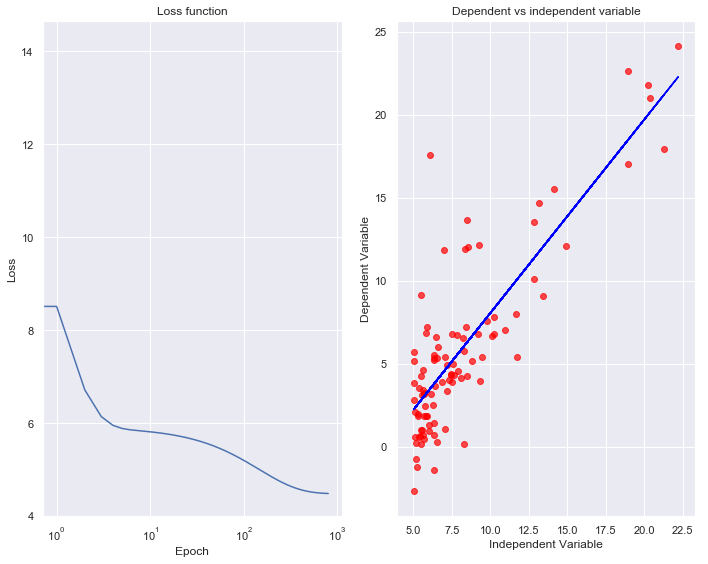

Normal Equations method Linear Reg model
Parameters are [-3.89578088  1.19303364]


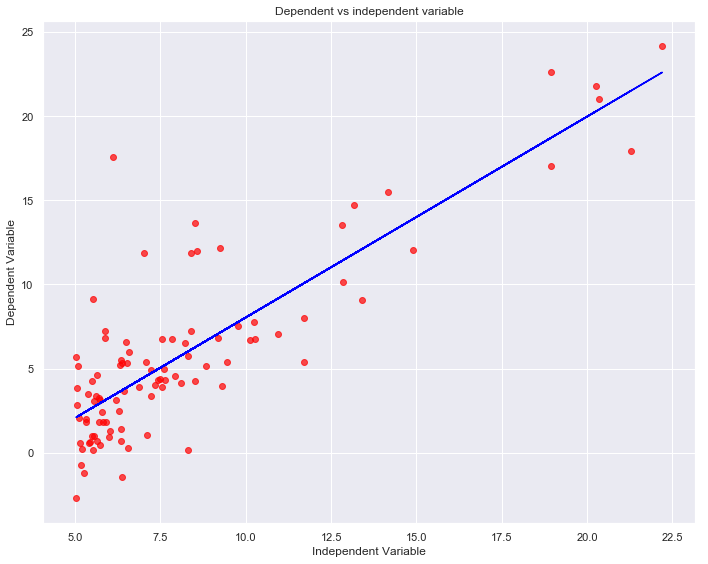

In [50]:
display_loss_best_fit(l1, X_feat, y_target)
display_loss_best_fit(l2, X_feat, y_target)

#### Calculate R square value

In [128]:
def calculate_rsquared(X_feat, y_target, theta_vector, percent=False):
    y_mean = y_target.mean()
    y_minus_y_mean = (y_target-y_mean)**2

    y_predicted = y_pred(X_feat, theta_vector)
    y_pred_mean = y_predicted.mean()
    y_pred_minus_y_pred_mean = (y_predicted-y_pred_mean)**2
    if percent:
        string = str((sum(y_pred_minus_y_pred_mean)/sum(y_minus_y_mean)) * 100)[:5]
        return string+" %"
    else:
        return (sum(y_pred_minus_y_pred_mean)/sum(y_minus_y_mean))

In [129]:
calculate_rsquared(X_feat, y_target, l1.theta_vector, True)

'67.21 %'